In [1]:
import graphix.command
from graphix.random_objects import Circuit, rand_circuit
from graphix.states import BasicStates
from graphix.sim.density_matrix import DensityMatrixBackend
from graphix.sim.statevec import StatevectorBackend, Statevec
from graphix.pauli import Pauli
from graphix.fundamentals import IXYZ
import stim
from veriphix.client import Client, Secrets, CircuitUtils
import veriphix.client
import numpy as np

/Users/sabdulsa/Codes/veriphix/.venv/lib/python3.12/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


Stim to Pattern

In [91]:
n = 8
for _ in range(1) :
    rd_circ_graphix = Circuit(n)
    rd_tableau = stim.Tableau.random(n)

    pattern = CircuitUtils.tableau_to_pattern(rd_tableau)

    print(f"The pattern has {pattern}")

    input_string = rd_tableau.inverse()(stim.PauliString("X"*n))
    sign_error = input_string.sign.real == -1
    input_state = [
        Pauli(IXYZ(pauli)).eigenstate() for pauli in input_string
    ]

    print(f"Pattern on {pattern.n_node} nodes")
    # pattern.standardize()
    pattern.minimize_space()

    # byproduct_db = veriphix.client.get_byproduct_db(pattern=pattern)
    # print(byproduct_db)
    # # pattern.get_byproduct_db()
    # # pattern.standardize()


    # print(pattern.output_nodes)
    # ## Measure output nodes, to have classical output
    classical_output = pattern.output_nodes
    for onode in classical_output:
        pattern.add(graphix.command.M(node=onode))

    # pattern.print_pattern(lim=150)
    # print(classical_output)

    backend = DensityMatrixBackend()
    pattern.simulate_pattern(backend=backend, input_state=input_state)

    
    if sum([pattern.results[i] for i in classical_output])%2 ^ sign_error == 0 :
        print("yyy")


The pattern has graphix.pattern.Pattern object with 972 commands and 8 output qubits
Pattern on 226 nodes
yyy


q0: -X-@-X---@-@---X---------------------
     | | |   | |   |
q1: -|-|-|-H-X-|-H-@-S-H-@---------------
     | | |     |         |
q2: -@-X-@-H---X-------H-X-S-H-S-H-S-S-H-
q0: -X-@-X---@-@---X---------------------
     | | |   | |   |
q1: -|-|-|-H-X-|-H-@-S-H-@---------------
     | | |     |         |
q2: -@-X-@-H---X-------H-X-S-H-S-H-S-S-H-


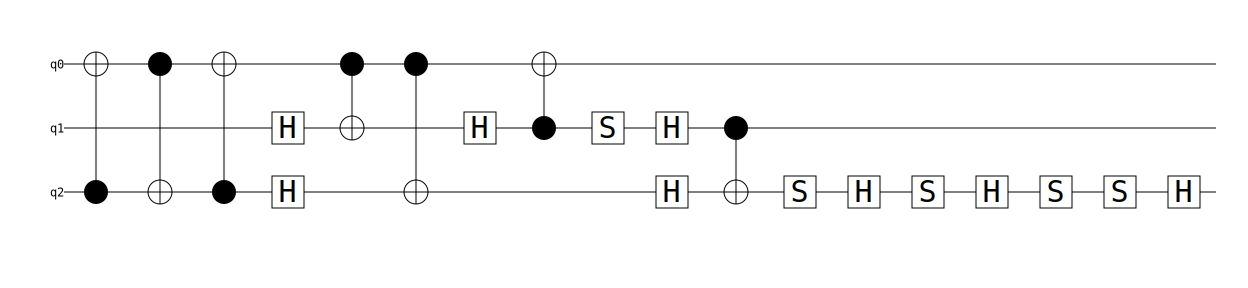

In [24]:
n = 3
rd_circ_graphix = Circuit(n)
rd_tableau = stim.Tableau.random(n)
# pattern = CircuitUtils.tableau_to_pattern(rd_tableau)


other_circuit = stim.Circuit()
rd_circ = rd_tableau.to_circuit()
# print(rd_circ)
for i in rd_circ:
    if i.name == "H":
        for t in i.target_groups():
            qubit = t[0].value
            # print(f"Hadamard on {qubit}")
            rd_circ_graphix.h(qubit)
            other_circuit.append("H", qubit)
            # print(qubit)
    if i.name == "S":
        # print("S on ")
        for t in i.target_groups():
            qubit = t[0].value
            rd_circ_graphix.s(qubit)
            other_circuit.append("S", qubit)
            # print(f"S on {qubit}")
            # print(qubit)
    if i.name == "CX":
        for t in i.target_groups():
            ctrl, targ = t[0].value, t[1].value

            rd_circ_graphix.cnot(control=ctrl, target=targ)
            other_circuit.append("CX", [ctrl, targ])
            # print(f"CX_(c,t) on {ctrl, targ} ")
            # print(ctrl, targ)
print(rd_circ.diagram())
print(other_circuit.diagram())
other_circuit.diagram(type="timeline-svg")



Generating the corresponding +1-eigenstate

In [12]:
# input_stabilizer = rd_tableau.inverse_x_output(0)

inverse_rd_tableau = rd_tableau.inverse()
reverse_string = inverse_rd_tableau(stim.PauliString("X"*n))
stim.Circuit
state = []
for pauli in reverse_string:
    operator = Pauli(IXYZ(pauli))
    state.append(operator.eigenstate())
print(reverse_string)
print(state)

+Y__
[graphix.states.PlanarState(Plane.XY, 1.5707963267948966), graphix.states.PlanarState(Plane.XY, 0.0), graphix.states.PlanarState(Plane.XY, 0.0)]


Running the pattern on the +1-eigenstate as input, and print("yyy") if it works

In [122]:
pattern = rd_circ_graphix.transpile().pattern
print(f"Pattern on {pattern.n_node} nodes")
pattern.minimize_space()


print(pattern.output_nodes)
## Measure output nodes, to have classical output
classical_output = pattern.output_nodes
for onode in classical_output:
    pattern.add(graphix.command.M(node=onode))

print(classical_output)

pattern.simulate_pattern(backend="densitymatrix", input_state=state)
if sum([pattern.results[i] for i in classical_output])%2 == 0 :
    print("yyy")

Pattern on 198 nodes
[181, 185, 189, 193, 128, 197, 177]
[181, 185, 189, 193, 128, 197, 177]


In [7]:

nqubits = 2
depth = 100
circuit = rand_circuit(nqubits, depth)
pattern = circuit.transpile().pattern 
pattern.minimize_space()

print(f"Number of nodes in the pattern : {pattern.n_node}")

## Measure output nodes, to have classical output
classical_output = pattern.output_nodes
for onode in classical_output:
    pattern.add(graphix.command.M(node=onode))



secrets = Secrets(r=True, a=True, theta=True)
client = Client(pattern=pattern, secrets=secrets)

n_good_output = 0

for _i in range(1):
    backend = DensityMatrixBackend()
    client.delegate_pattern(backend=backend)

Number of nodes in the pattern : 865
Number of occurrences of output '00' : 1
